# ***PyTorch Native Distributed Training with Amazon SageMaker***

In [9]:
# !pip install sagemaker --upgrade -q
# !pip install ipywidgets -q

**Step 1:** Import essentials packages, start a sagemaker session and specify the bucket name you created in the pre-requsites section of this workshop.

In [10]:
import os
import boto3
import time
import numpy as np
import sagemaker

## Housekeeping: need access to the session for sagemaker and client
sess = boto3.Session()
sm   = sess.client('sagemaker')
sagemaker_session = sagemaker.Session()

## Getting an execution role - this is needed for sagemaker to access
## other services
role = sagemaker.get_execution_role()

## Creates a default bucket to save the s3 models in sagemaker
bucket_name    = sagemaker_session.default_bucket()
jobs_folder    = 'jobs'
dataset_folder = 'datasets'

![](https://miro.medium.com/max/1000/0*GRfvsrvtfpRm400-)

#### Prepare the training data
The CIFAR-10 dataset is a subset of the 80 million tiny images dataset. It consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

In [11]:
## Importing torchvision
import torchvision

## Using this model (step up from mnest)
cifar10_dataset = torchvision.datasets.CIFAR10('cifar10-dataset', 
                                     train=True, 
                                     download=True)

## Uploading the dataset into s3 after downloading it locally
datasets = sagemaker_session.upload_data(path='cifar10-dataset', 
                                         key_prefix=f'{dataset_folder}/cifar10-dataset')

datasets

Files already downloaded and verified


's3://sagemaker-us-east-1-442851008302/datasets/cifar10-dataset'

**Step 2:** Specify hyperparameters, instance type and number of instances to distribute training to. 

In [12]:

job_name   = f'pytorch-native-dist-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'
output_path = f's3://{bucket_name}/{jobs_folder}'


## Specifying hyperparameters (not hardcoded because then we cannot run 
## experiments on Sagemaker).

## Here, we can work with the numbers, and spin up multiple jobs, and makes
## it much easier to experiment.
hyperparameters = {'epochs'       : 20, 
                   'lr'           : 0.01,
                   'momentum'     : 0.9,
                   'batch-size'   : 64,
                   'model-type'   : 'custom',
                   'backend'      : 'gloo'}

In [13]:
from sagemaker.pytorch import PyTorch

## Represents the pytorch estimator function, given below is the 
## pytorch training script, where it is at.

## we can also talk about the path, where we store the training job
estimator = PyTorch(entry_point         = 'cifar10-distributed-native-cpu.py', 
                           source_dir           = 'code',
                           output_path          = output_path + '/',
                           code_location        = output_path,
                           role                 = role,
                            ## we need to specify the instance count: 2, 4, 8 and so on
                           instance_count       = 2,
                            
                            ## We select the instance type for the types of these instances
                           instance_type        = 'ml.c5.2xlarge',
                           framework_version    = '1.8.0', 
                           py_version           = 'py3',
                           hyperparameters      = hyperparameters)

**Step 4:** Specify dataset locations in Amazon S3 and then call the fit function.

In [14]:
## To fit the function, we use estimator.fit to kickstart the training job
## instructs SM to start the training instances, copies the data from and copies into s3
estimator.fit({'train': datasets}, 
              job_name=job_name, 
              wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-native-dist-2023-07-25-21-21-24-206


Using provided s3_resource
2023-07-25 21:21:25 Starting - Starting the training job...
2023-07-25 21:21:41 Starting - Preparing the instances for training......
2023-07-25 21:22:38 Downloading - Downloading input data...
2023-07-25 21:23:13 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-25 21:23:25,605 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-25 21:23:25,607 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-25 21:23:25,616 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-25 21:23:25,618 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-25 21:23:25,826 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-25 21:23:25,838 sagemaker-tr

Average accuracy is about 60%, and there are some custom models that can get us to 90-95%.

We have created the model, SM has uploaded to s3.

estimator.model_data

In [15]:
estimator.model_data

's3://sagemaker-us-east-1-442851008302/jobs/pytorch-native-dist-2023-07-25-21-21-24-206/output/model.tar.gz'

In [16]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

## Now, we will host the model that we have trained

## we can host this model as an endpoint by creating a model
model = PyTorchModel(
    
    ## the estimator.model function will tell us the location of our model
    model_data=estimator.model_data,
    source_dir="code",
    entry_point="inference.py",
    role=role,
    framework_version="1.6.0",
    py_version="py3",
)

## Model.deploy makes sagemaker host this endpoint
predictor = model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-25-21-39-12-870
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-25-21-39-13-639
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-25-21-39-13-639


----!

In [19]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

##now to invoke the model, we will load the data
def test_data_loader():
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    testset = torchvision.datasets.CIFAR10(root="cifar10-dataset", 
                                           train=False, 
                                           download=False, 
                                           transform=transform)                                            
    return torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

def show_img(img):
    """displays an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

GroundTruth:  plane  car  car truck
Predicted:    bird deer  car  cat


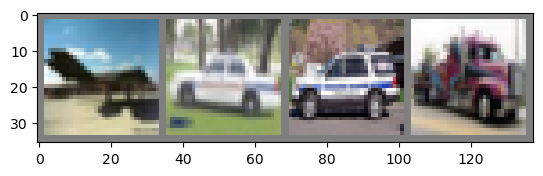

In [22]:
# get some test images
## dataiter = iter(test_data_loader())
## images, labels = dataiter.next()

dataiter = iter(test_data_loader())
images, labels = next(dataiter)

# print images, labels, and predictions
show_img(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))
outputs = predictor.predict(images)
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted:   ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

This is how we can host the model endpoint and give the groudtruth and the predicted by using a distributed manner of training the dataset using pytorch.